In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar os dados limpos

In [4]:
df = pd.read_parquet('data/silver/dados_limpos.parquet')

# Completude de Dados

### É uma métrica de qualidade que mede a porcentagem de dados que estão realmente preenchidos no seu conjunto de dados.

In [5]:
print("\n1. COMPLETUDE DOS DADOS")
print("-" * 50)
total_celulas = df.shape[0] * df.shape[1]
celulas_preenchidas = df.count().sum()
completude_geral = (celulas_preenchidas / total_celulas) * 100
print(f"Completude Geral: {completude_geral:.2f}%")
print("\nCompletude por coluna:")
for coluna in df.columns:
    valores_preenchidos = df[coluna].count()
    total = len(df)
    percentual = (valores_preenchidos / total) * 100
    print(f" {coluna}: {percentual:.2f}%")


1. COMPLETUDE DOS DADOS
--------------------------------------------------
Completude Geral: 97.51%

Completude por coluna:
 InvoiceNo: 100.00%
 StockCode: 100.00%
 Description: 99.98%
 Quantity: 100.00%
 InvoiceDate: 100.00%
 UnitPrice: 100.00%
 CustomerID: 75.07%
 Country: 100.00%
 data_ingestao: 100.00%
 fonte_arquivos: 100.00%


# Unicidade

### É garantir que não existem dados duplicados no seu conjunto de dados.

In [6]:
print("\n2. UNICIDADE DOS DADOS")
print("-" * 50)
duplicatas = df.duplicated().sum()
unicidade = ((len(df) - duplicatas) / len(df)) * 100
print(f"Linhas únicas: {unicidade:.2f}%")
print(f"Duplicatas encontradas: {duplicatas}")


2. UNICIDADE DOS DADOS
--------------------------------------------------
Linhas únicas: 99.03%
Duplicatas encontradas: 5270


# Consistência

In [7]:
print("\n3. CONSISTÊNCIA DOS DADOS")
print("-" * 50)

# Valores negativos
qty_negativos = (df['Quantity'] <= 0).sum()
price_negativos = (df['UnitPrice'] <= 0).sum()
print(f"Quantity negativos/zero: {qty_negativos}")
print(f"UnitPrice negativos/zero: {price_negativos}")

# Cancelamentos e ajustes
cancelamentos = df['InvoiceNo'].astype(str).str.startswith('C').sum()
ajustes = df['InvoiceNo'].astype(str).str.startswith('A').sum()
print(f"Cancelamentos (InvoiceNo 'C'): {cancelamentos}")
print(f"Ajustes (InvoiceNo 'A'): {ajustes}")

# Tarifas
stockcode_fees = ['C2', 'DOT', 'POST', 'AMAZONFEE']
tarifas = df['StockCode'].isin(stockcode_fees).sum()
print(f"Linhas de tarifas: {tarifas}")



3. CONSISTÊNCIA DOS DADOS
--------------------------------------------------
Quantity negativos/zero: 10624
UnitPrice negativos/zero: 2517
Cancelamentos (InvoiceNo 'C'): 9288
Ajustes (InvoiceNo 'A'): 3
Linhas de tarifas: 2144


# Validade

In [8]:
print("\n4. VALIDADE DOS DADOS")
print("-" * 50)

# Outliers em Quantity
Q1_qty = df[df['Quantity'] > 0]['Quantity'].quantile(0.25)
Q3_qty = df[df['Quantity'] > 0]['Quantity'].quantile(0.75)
IQR_qty = Q3_qty - Q1_qty
outliers_qty = ((df['Quantity'] < (Q1_qty - 1.5 * IQR_qty)) | 
                (df['Quantity'] > (Q3_qty + 1.5 * IQR_qty))).sum()
print(f"Outliers em Quantity: {outliers_qty}")

# Outliers em UnitPrice
Q1_price = df[df['UnitPrice'] > 0]['UnitPrice'].quantile(0.25)
Q3_price = df[df['UnitPrice'] > 0]['UnitPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price
outliers_price = ((df['UnitPrice'] < (Q1_price - 1.5 * IQR_price)) | 
                  (df['UnitPrice'] > (Q3_price + 1.5 * IQR_price))).sum()
print(f"Outliers em UnitPrice: {outliers_price}")


4. VALIDADE DOS DADOS
--------------------------------------------------
Outliers em Quantity: 58619
Outliers em UnitPrice: 39627


# Visualização


Gráfico salvo em: data/quality_report.png


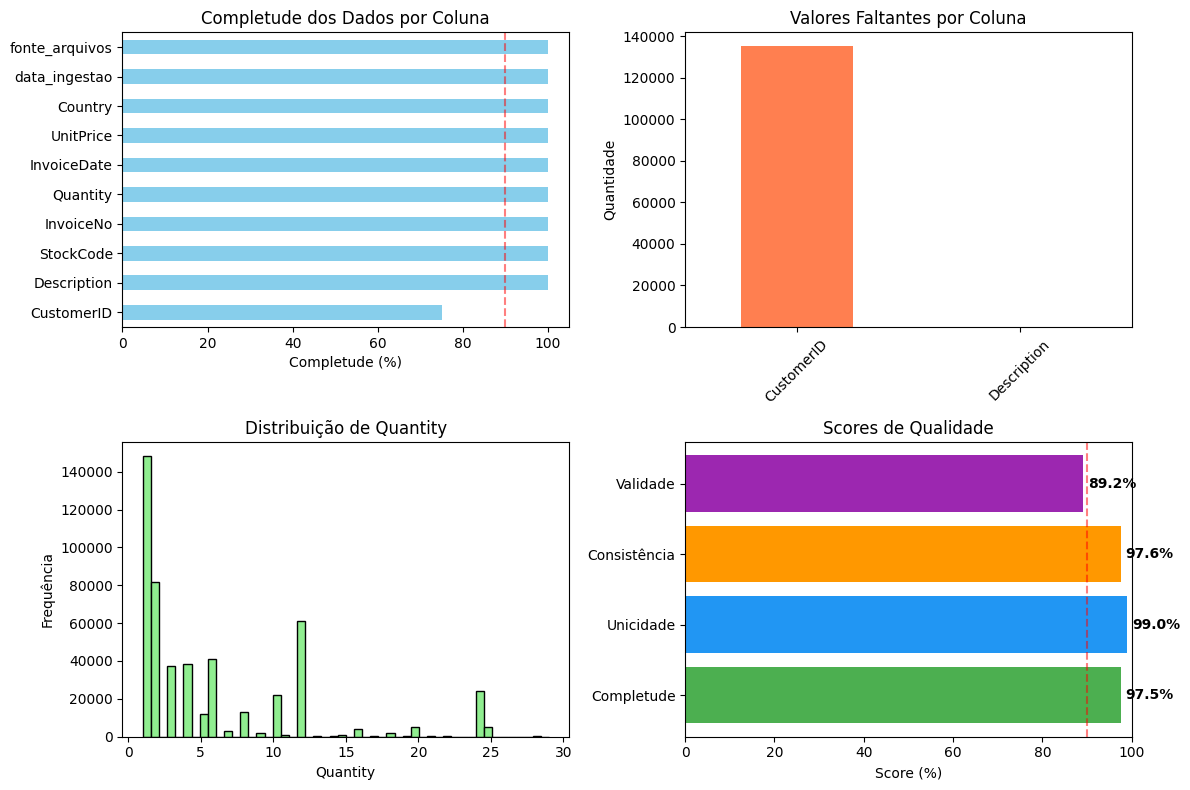

In [9]:
plt.figure(figsize=(12, 8))

# Completude
plt.subplot(2, 2, 1)
completude_colunas = (df.count() / len(df)) * 100
completude_series = pd.Series(completude_colunas).sort_values()
completude_series.plot(kind='barh', color='skyblue')
plt.xlabel('Completude (%)')
plt.title('Completude dos Dados por Coluna')
plt.axvline(x=90, color='r', linestyle='--', alpha=0.5)

# Valores faltantes
plt.subplot(2, 2, 2)
valores_faltantes = df.isnull().sum().sort_values(ascending=False)
valores_faltantes = valores_faltantes[valores_faltantes > 0]
if len(valores_faltantes) > 0:
    valores_faltantes.plot(kind='bar', color='coral')
    plt.ylabel('Quantidade')
    plt.title('Valores Faltantes por Coluna')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'Sem valores faltantes', ha='center', va='center')
    plt.title('Valores Faltantes')

# Distribuição Quantity
plt.subplot(2, 2, 3)
qty_plot = df[(df['Quantity'] > 0) & (df['Quantity'] <= df['Quantity'].quantile(0.95))]
plt.hist(qty_plot['Quantity'], bins=50, color='lightgreen', edgecolor='black')
plt.xlabel('Quantity')
plt.ylabel('Frequência')
plt.title('Distribuição de Quantity')

# Score Final
plt.subplot(2, 2, 4)
inconsistencias = qty_negativos + price_negativos
score_consistencia = max(0, 100 - (inconsistencias / len(df) * 100))
score_validade = max(0, 100 - (outliers_qty / len(df) * 100))

scores = [completude_geral, unicidade, score_consistencia, score_validade]
labels = ['Completude', 'Unicidade', 'Consistência', 'Validade']
colors = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0']

bars = plt.barh(labels, scores, color=colors)
plt.xlim(0, 100)
plt.xlabel('Score (%)')
plt.title('Scores de Qualidade')
plt.axvline(x=90, color='r', linestyle='--', alpha=0.5)

for bar, score in zip(bars, scores):
    plt.text(score + 1, bar.get_y() + bar.get_height()/2, 
             f'{score:.1f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('data/quality_report.png', dpi=300, bbox_inches='tight')
print("\nGráfico salvo em: data/quality_report.png")

# Score final

In [10]:
print("SCORE GERAL DE QUALIDADE")
print("="*50)

score_final = (completude_geral * 0.35 + unicidade * 0.25 + 
               score_consistencia * 0.20 + score_validade * 0.20)

print(f"\nCompletude: {completude_geral:.2f}%")
print(f"Unicidade: {unicidade:.2f}%")
print(f"Consistência: {score_consistencia:.2f}%")
print(f"Validade: {score_validade:.2f}%")
print(f"\nScore Final: {score_final:.2f}%")

if score_final >= 90:
    print("Classificação: EXCELENTE")
elif score_final >= 80:
    print("Classificação: BOM")
elif score_final >= 70:
    print("Classificação: REGULAR")
else:
    print("Classificação: NECESSITA MELHORIAS")

plt.show()

SCORE GERAL DE QUALIDADE

Completude: 97.51%
Unicidade: 99.03%
Consistência: 97.58%
Validade: 89.18%

Score Final: 96.24%
Classificação: EXCELENTE
